In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats

import plotly.express as px
import matplotlib.pyplot as plt

from scipy.stats import chi2_contingency, chi2, mannwhitneyu, shapiro, kruskal
import statsmodels.api as sa 
import scikit_posthocs as sp  # sp.posthoc_dunn() для непараметрического аналога anova 
import pingouin as pg

/opt/tljh/user/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedCacheFailedWarning: Failed to use cache while checking for outdated package.
Set the environment variable OUTDATED_RAISE_EXCEPTION=1 for a full traceback.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs
/opt/tljh/user/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.1, the latest is 0.2.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


In [2]:
user_data = pd.read_csv('ab_users_data.csv')
orders = pd.read_csv('ab_orders.csv')
products = pd.read_csv('ab_products.csv')

/opt/tljh/user/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.4.0, the latest is 0.5.5.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


In [3]:
# Мерджим пользователей с заказами
merged_df = user_data.merge(orders, on='order_id')

In [6]:
merged_df

,user_id,order_id,action,time,date,group,creation_time,product_ids
0,964,1255,create_order,2022-08-26 00:00:19.000000,2022-08-26,0,2022-08-26 00:00:19.000000,"{75, 22, 53, 84}"
1,965,1256,create_order,2022-08-26 00:02:21.000000,2022-08-26,1,2022-08-26 00:02:21.000000,"{56, 76, 39}"
2,964,1257,create_order,2022-08-26 00:02:27.000000,2022-08-26,0,2022-08-26 00:02:27.000000,"{76, 34, 41, 38}"
3,966,1258,create_order,2022-08-26 00:02:56.000000,2022-08-26,0,2022-08-26 00:02:56.000000,"{74, 6}"
4,966,1258,cancel_order,2022-08-26 00:08:25.486419,2022-08-26,0,2022-08-26 00:02:56.000000,"{74, 6}"
...,...,...,...,...,...,...,...,...
4332,990,59422,create_order,2022-09-08 23:13:03.000000,2022-09-08,1,2022-09-08 23:13:03.000000,"{84, 8, 24}"
4333,1418,59439,create_order,2022-09-08 23:18:05.000000,2022-09-08,1,2022-09-08 23:18:05.000000,"{9, 25, 75, 30, 6}"
4334,1605,59464,create_order,2022-09-08 23:22:27.000000,2022-09-08,0,2022-09-08 23:22:27.000000,"{60, 41, 46}"
4335,1461,59487,create_order,2022-09-08 23:29:06.000000,2022-09-08,0,2022-09-08 23:29:06.000000,"{9, 62, 77}"


In [7]:
# Переводим столбец с товарами в список
merged_df['product_id'] = merged_df.product_ids.apply(lambda x: x.replace('{','').replace('}','').split(','))

In [8]:
# Добавляем столбец с количеством товаров в заказе 
merged_df['count_products'] = merged_df.product_id.apply(lambda x: len(x))

In [9]:
# Разворачиваем датафрейм по спискам id продуктов
new_df = merged_df.explode('product_id')

In [10]:
# Переводим колонку в числовое  значения, чтоб мерджить без ошибок
new_df.product_id = new_df.product_id.apply(lambda x: int(x))

In [11]:
# Мерджим датафрейм с товарами
all_merged = new_df.merge(products, on='product_id')

## Первой метрикой выбираем количество купленных товаров на пользователя

In [40]:
# Находим сколько товаров купил каждый пользователь
user_products = all_merged.groupby(['user_id', 'group']).size().reset_index(name='product_count')
# Определяем среднее по группам
user_products.groupby('group').agg({'product_count':'mean'})
# Видно,что среднее количество товаров на пользователя в тестовой группе заметно увеличилось

,product_count
group,
0,11.023301
1,17.713147


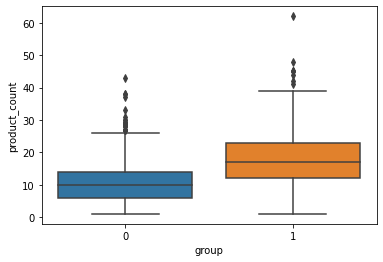

In [45]:
sns.boxplot(data=user_products, x="group", y="product_count")

In [54]:
# Формулируем гипотезу
# Н0- среднее количество товаров на пользователя в двух группах не различаются
# Н1 - среднее количество товаров в группах статистически значимо отличается
# Проверяем критерией Манна-Уитни
stat, p_value= stats.mannwhitneyu(user_products.query('group==1').product_count, user_products.query('group==0').product_count)
print(f'p-value = {p_value}')
if p_value < 0.05:
    print('Распределения в группах различны')
else:
    print('Распределения не отличаются')
#  Можно отклонить Н0. В тестовой группе среднее количество заказываемых товаров статистически значимо увеличилось

p-value = 4.75758587270406e-41
Распределения в группах различны


## Второй метрикой выбираем выручку на пользователя

In [43]:

# Находим сколько потратил каждый пользователь
user_costs = all_merged.groupby(['user_id', 'group']).agg({'price':'sum'}).reset_index()
# Определяем среднее по группам
user_costs.groupby('group').agg({'price':'mean'})

# Видно,что средняя сумма покупок на пользователя в тестовой группе заметно увеличилось

,price
group,
0,1249.556699
1,1951.863745


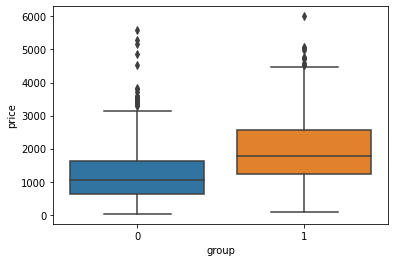

In [44]:
sns.boxplot(data=user_costs, x="group", y="price")

In [55]:
# Формулируем гипотезу
# Н0- среднее выручка на пользователя в двух группах не различаются
# Н1 - средняя выручка в группах статистически значимо отличается
# Проверяем критерией Манна-Уитни
stat, p_value= stats.mannwhitneyu(user_costs.query('group==1').price, user_costs.query('group==0').price)
print(f'p-value = {p_value}')
if p_value < 0.05:
    print('Распределения в группах различны')
else:
    print('Распределения не отличаются')
#  Можно отклонить Н0. В тестовой группе выручка на пользователя статистически значимо увеличилась

p-value = 2.1569099776088512e-32
Распределения в группах различны


## Третьей метрикой выбираем средний чек

In [58]:
# Формулируем гипотезу
# Н0- средний чек в двух группах не различается
# Н1 - среднстатистически значимо отличается

# Группируем данные, чтоб найти общую сумму по каждому заказу в каждой группе
check = all_merged.groupby(['order_id', 'group', 'count_products']).agg({'price':'sum'}).reset_index()

In [137]:
# Проверяем нормальность распределения в группах
# Распределения не являются нормальными
shapiro(np.log(check.query('group==0').price))

ShapiroResult(statistic=0.9790028929710388, pvalue=1.3455193753066867e-14)

In [138]:
shapiro(np.log(check.query('group==1').price))

ShapiroResult(statistic=0.9804280996322632, pvalue=4.053387247169605e-18)

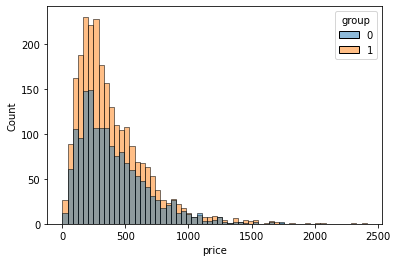

In [158]:
# построили гистограмму суммы заказа по группам
sns.histplot(data=check, x=check.price, hue='group')

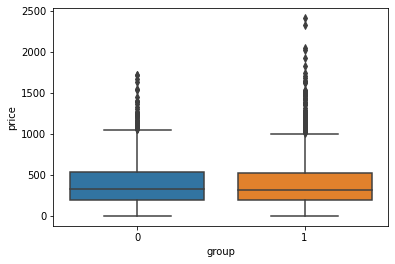

In [130]:
sns.boxplot(data=check, x="group", y="price")

In [59]:
stat, p_value= stats.mannwhitneyu(check.query('group==1').price, check.query('group==0').price)
print(f'p-value = {p_value}')
if p_value < 0.05:
    print('Распределения в группах различны')
else:
    print('Распределения не отличаются')
#  Н0 отклонить нельзя. Средние чеки значимо не различаются

p-value = 0.059910831685773505
Распределения не отличаются


## ВЫВОД: Новая система рекомендаций увеличивает количество купленных товаров и выручку на пользователя. 